In [2]:
import scipy.io as sio
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import time
from tensorflow.contrib.slim import fully_connected as fc
from tensorflow.python.ops.parallel_for.gradients import jacobian
import pandas as pd
import seaborn as sn
import cv2
import random

In [3]:
train = sio.loadmat('train.mat')
test = sio.loadmat('test.mat')
G = sio.loadmat('G.mat')
PHI_ALL = sio.loadmat('PHI_ALL.mat')
LOGPERM_MEAN = sio.loadmat('logmean.mat')
w = 100
h = 100
train = np.array(train["train"]).transpose()
test = np.array(test["test"]).transpose()
G = np.array(G["G"]).transpose()
PHI_ALL = np.array(PHI_ALL["PHI_ALL"]).transpose()
LOGPERM_MEAN = np.array(LOGPERM_MEAN["logmean"]).transpose()
input_dim = w*h
num_sample = 2000
totals = 5
maxiter = 4
kpers = 6
totalk = totals*kpers
PHIMIX = sio.loadmat('PHIMIX.mat')
PHIMIX = np.array(PHIMIX["PHIMIX"]).transpose()
k=[83,53,53,35,35];
n1=0
n2=0
PHI = np.zeros((np.sum(k),10000))
print(train.shape)
print(test.shape)
print(G.shape)
print(PHI_ALL.shape)
print(LOGPERM_MEAN.shape)
print(PHI.shape)
for nf in range(totals):
    n2 =k[nf]+n2
    PHI[n1: n2] = PHI_ALL[nf*100:nf*100+k[nf]]
    n1 = k[nf]+n1
    
k=[19,9,9,6,6];
n1=0
n2=0
PHIn = np.zeros((np.sum(k),10000))
for nf in range(totals):
    n2 =k[nf]+n2
    PHIn[n1: n2] = PHI_ALL[nf*100:nf*100+k[nf]]
    n1 = k[nf]+n1

(2000, 10000)
(500, 10000)
(10000, 50)
(500, 10000)
(1, 10000)
(259, 10000)


In [5]:
def viz_grid3(Xs, padding, gh, gw,pad_value):
    
    N, H, W = Xs.shape
    #grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * gh + padding * (gh + 1)
    grid_width = W * gw + padding * (gw + 1)
    
    
    grid = np.ones((grid_height, grid_width))*pad_value
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(gh):
        x0, x1 = padding, W + padding
        for x in range(gw):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

In [4]:
def vizfilter(model,scope,gh,gw):
    with model.sess.as_default():
        with tf.variable_scope(scope, reuse=True):
            conv1 = tf.get_variable("weights")
            b1    = tf.get_variable("biases")
        w = conv1.eval()
        w_01 = np.array(w)
        w_01 = (w_01-w_01.min())/(w_01.max()-w_01.min())
        wT = w_01.transpose((3,0,1,2))
        rgb_w = []
        n, H, W, C = wT.shape
        rgb_w = wT
        rgb_w = np.asarray(rgb_w)
        grid = viz_grid3(Xs = rgb_w[:,:,:,0],padding = 1,gh = gh,gw = gw,pad_value = 1)
        fig = plt.figure(figsize = (gw,gh))   
        ax1 = plt.subplot(111)
        ax1.imshow(grid,cmap='gray_r')
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
        ax1.set_title('Learned {} Filters'.format(scope), fontsize=15)
        cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
        cb = mpl.colorbar.ColorbarBase(cax, cmap='gray_r', norm = mpl.colors.Normalize(vmin=0, vmax=1),spacing='proportional')

In [5]:
class CNN(object):

    def __init__(self, conv1n):

        tf.reset_default_graph()
        self.conv1n = conv1n
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])
        self.labels = tf.placeholder(
            name='labels', dtype=tf.int64, shape=[None, 5])
        self.learning_rate = tf.placeholder(name = 'learning_rate',dtype = tf.float32,shape = None)
        self.drate = tf.placeholder(name = 'drate',dtype = tf.float32,shape = None)
        self.onehotgrad = tf.placeholder(name = 'onehotgrad',dtype = tf.float32,shape = [None,5])
        self.l1c = tf.placeholder(name = 'l1c',dtype = tf.float32,shape = None)
        self.l2c = tf.placeholder(name = 'l2c',dtype = tf.float32,shape = None)
        inp0 = tf.nn.dropout(self.x,rate = self.drate)
        inp = tf.reshape(inp0,[-1,100,100,1])
        
        self.conv1 = tf.contrib.layers.conv2d(inp,self.conv1n,[5,5],stride=1,
                                 padding='Same',activation_fn=tf.nn.relu,scope = 'Conv1')
 
        print(self.conv1.shape)
        mp1 = tf.contrib.layers.avg_pool2d(self.conv1,[2,2])
        d1 = tf.nn.dropout(mp1,rate = self.drate)
        self.conv2 = tf.contrib.layers.conv2d(d1,self.conv1n*2,[5,5],stride=1,
                                 padding='Same',activation_fn=tf.nn.relu,scope = 'Conv2')
        print(self.conv2.shape)
        self.mp2 = tf.contrib.layers.avg_pool2d(self.conv2,[2,2])
        d2 = tf.nn.dropout(self.mp2,rate = self.drate)
        
        self.conv3 = tf.contrib.layers.conv2d(d2,self.conv1n*4,[3,3],stride=1,
                                 padding='Same',activation_fn=tf.nn.relu,scope = 'Conv3')
        print(self.conv3.shape)
        self.mp3 = tf.contrib.layers.avg_pool2d(self.conv3,[2,2])
        d3 = tf.nn.dropout(self.mp3,rate = self.drate)
        self.conv4 = tf.contrib.layers.conv2d(d3,self.conv1n*8,[3,3],stride=1,
                                 padding='Same',activation_fn=tf.nn.relu,scope = 'Conv4')
        print(self.conv4.shape)
        self.conv5 = tf.contrib.layers.conv2d(self.conv4,self.conv1n*8,[3,3],stride=1,
                                 padding='Same',activation_fn=tf.nn.relu,scope = 'Conv5')
        print(self.conv5.shape)
        self.mp4 = tf.contrib.layers.max_pool2d(self.conv5,[2,2])
        
        print(d3.shape)
        flate1 = tf.reshape(self.mp4,[-1,6*6*self.conv1n*8])
        self.logits =fc(flate1, 5, scope='FC1',activation_fn=None)
        print(self.logits.shape)
        print(self.labels.shape)
        self.l2w = sum(tf.nn.l2_loss(var) for var in tf.trainable_variables() if not 'biases' in var.name)
        self.l2b = sum(tf.nn.l2_loss(var) for var in tf.trainable_variables() if not 'weights' in var.name)
        self.l1w = sum(tf.reduce_sum(tf.abs(var)) for var in tf.trainable_variables() if not 'biases' in var.name)
        self.l1b = sum(tf.reduce_sum(tf.abs(var)) for var in tf.trainable_variables() if not 'weights' in var.name)
        self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
        #self.total_loss = self.loss
        self.total_loss = self.loss  + self.l2c*self.l2w + self.l2c*self.l2b +self.l1c*self.l1w +self.l1c*self.l1b
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'loss': self.loss,
            'total_loss': self.total_loss,
            'L1':self.l1w,
            'L2':self.l2w
        }     
        self.prob = tf.nn.softmax(self.logits)
        self.correct = tf.equal(tf.argmax(self.prob,1), tf.argmax(self.labels, 1))
        self.accuracy=tf.reduce_mean(tf.cast(self.correct, tf.float32))
        self.y_c = tf.reduce_sum(tf.multiply(self.logits,self.onehotgrad)+tf.constant(1e-5),axis = 1)
        self.grad = tf.gradients(self.y_c,self.mp2)[0]
        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x,labels,learning_rate,drate,l1c,l2c):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x,self.labels: labels, self.learning_rate:learning_rate,self.drate: drate
                      ,self.l1c:l1c, self.l2c:l2c}
        )
        return losses

    # x -> x_hat
    def predictprob(self, x):
        drate = 0
        prob = self.sess.run(self.prob, feed_dict={self.x: x,self.drate: drate})
        
        return prob
    def predictclass(self, x):
        drate = 0
        logits = self.sess.run(self.logits, feed_dict={self.x: x,self.drate: drate})
        return pclass
    def calaccuracy(self,x,label):
        drate = 0
        accuracy = self.sess.run(self.accuracy, feed_dict={self.x: x,self.labels:label,self.drate: drate})
        
        return accuracy
    def caljacob(self,x,label,l1c,l2c):
        drate = 0
        jacob = self.sess.run(jacobian(self.total_loss,self.x), feed_dict={self.x:x,self.labels:label,self.drate:drate
                                                                          ,self.l1c:l1c, self.l2c:l2c})
        return jacob
    def gradcam(self,x,nlabel):
        drate = 0
        onehotgrad = np.zeros((1,5))
        onehotgrad[0,nlabel] = 1
        gradcam = self.sess.run(self.grad,feed_dict={self.x:x,self.drate:drate,self.onehotgrad:onehotgrad})
        return gradcam
    def actmp2(self,x):
        drate = 0
        actmp2 = self.sess.run(self.mp4,feed_dict = {self.x:x,self.drate:drate})
        return actmp2

In [7]:
def trainer(
    model_object,convl1n,
    learning_rate=1e-4, batch_size=64, train = train,test = test,
    num_epochs=100, log_step=10, rnv = 1, rbv = 1, rnc = 0.5, rbc = 0.5,drate = 0,l1c = 0,l2c = 0,savename = "tf_models/SPCNN.ckpt"):
    model = model_object(
      convl1n
    )
    trainlabels = np.zeros((2000,5))
    testlabels = np.zeros((500,5))
    for iscenario in range(5):
        trainlabels[iscenario*400:(iscenario+1)*400,iscenario] = 1
    for iscenario in range(5):
        testlabels[iscenario*100:(iscenario+1)*100,iscenario] = 1
    #print(testlabels[0])
    for epoch in range(num_epochs):
        start_time = time.time()
        seq = np.random.permutation(2000)
        traini = train[seq]
        noise1 = np.random.normal(0, rbv, (2000,PHIn.shape[0]))
        noise2 = np.random.normal(0, rnv, traini.shape)
        traini = traini + rbc*noise1@PHIn + rnc*noise2
        labelsi = trainlabels[seq]
        for iter in range(2000 // batch_size):
            batch = traini[iter*batch_size:(iter+1)*batch_size]
            batchl = labelsi[iter*batch_size:(iter+1)*batch_size]
            losses = model.run_single_step(batch,batchl,learning_rate,drate =drate,l1c = l1c, l2c = l2c)
        end_time = time.time()
        if epoch % log_step == 0:
            acc = model.calaccuracy(train,trainlabels)
            log_str = '[Epoch: {}] '.format(epoch)
            log_str += 'Accuracy: {:.3f}, '.format(acc)
            for k, v in losses.items():
                log_str += '{}: {:.3f}, '.format(k, v)
            log_str += '({:.3f}sec/epoch)'.format(end_time - start_time)
            print(log_str)
            acc = model.calaccuracy(testpca,testlabels)
            log_str = 'Accuracy: {:.3f}, '.format(acc)
            print(log_str)
        if epoch % 50== 0:
            learning_rate = learning_rate*0.95
            acc = model.calaccuracy(testpca,testlabels)
            log_str = 'Accuracy: {:.3f}, '.format(acc)
            print(log_str)
            vizfilter(model,'Conv1',2,5)
            vizfilter(model,'Conv2',4,5)
    saver = tf.train.Saver()
    model_path = saver.save(model.sess, savename)
    acc = model.calaccuracy(train,trainlabels)
    log_str = '[Epoch: {}] '.format(epoch)
    log_str += 'Accuracy: {:.3f}, '.format(acc)
    for k, v in losses.items():
        log_str += '{}: {:.3f}, '.format(k, v)
    log_str += '({:.3f}sec/epoch)'.format(end_time - start_time)
    print(log_str)
    acc = model.calaccuracy(testpca,testlabels)
    log_str = 'Accuracy: {:.3f}, '.format(acc)
    vizfilter(model,'Conv1',2,5)
    vizfilter(model,'Conv2',4,5)
    print(log_str)
    
    print("Model saved in %s" % model_path)
    print('Done')
    return model

In [19]:
model.sess.close()

(?, 12, 12, 40)
(?, 5)
(?, 5)
[Epoch: 0] Accuracy: 0.198, loss: 1.611, total_loss: 1.624, L1: 3869.044, L2: 92.281, (1.500sec/epoch)
Accuracy: 0.206, 
Accuracy: 0.206, 
[Epoch: 10] Accuracy: 0.200, loss: 1.602, total_loss: 1.615, L1: 3826.083, L2: 90.903, (1.405sec/epoch)
Accuracy: 0.200, 
[Epoch: 20] Accuracy: 0.292, loss: 1.606, total_loss: 1.618, L1: 3759.994, L2: 88.496, (1.457sec/epoch)
Accuracy: 0.276, 
[Epoch: 30] Accuracy: 0.715, loss: 0.491, total_loss: 0.505, L1: 3861.194, L2: 96.858, (1.448sec/epoch)
Accuracy: 0.626, 
[Epoch: 40] Accuracy: 0.866, loss: 0.204, total_loss: 0.218, L1: 3900.160, L2: 101.172, (1.443sec/epoch)
Accuracy: 0.778, 
[Epoch: 49] Accuracy: 0.907, loss: 0.283, total_loss: 0.297, L1: 3926.290, L2: 104.320, (1.479sec/epoch)
Accuracy: 0.790, 
Model saved in tf_models/CNNvisual105.ckpt
Done


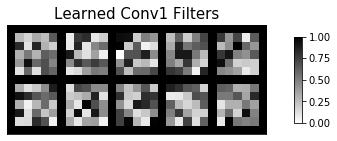

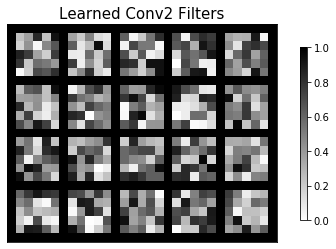

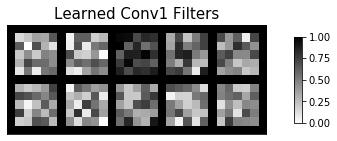

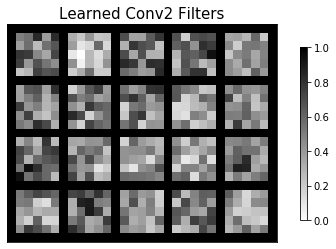

In [100]:
model = trainer(CNN, 10,num_epochs=50, learning_rate=5e-4, batch_size=50,
                train = trainpca,rnc = 2, rbc = 7,drate = 0.7, l1c = 0.000001, l2c = 0.0001,savename = "tf_models/CNNvisual105.ckpt")

In [8]:
model = CNN(10)
saver = tf.train.Saver()
saver.restore(model.sess, "tf_models/CNNvisual104.ckpt")

Instructions for updating:
Colocations handled automatically by placer.
(?, 12, 12, 40)
(?, 5)
(?, 5)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf_models/CNNvisual104.ckpt


In [90]:
model.sess.close()